In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import os
import regex as re
import random
import importlib
import sys

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_context('talk')

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [2]:
############################
#   Experiment parameter   #
############################

EXPERIMENT_NAME = 'BLUEPRINT_B'   # uniform or proportionate
N = 10
SEED = 888
TOTAL_READS_TO_SAMPLE = 1000000
CELLTYPES = ['Blueprint-B', 'Blueprint-CD4', 'Blueprint-CD8', 'Blueprint-NK', 'Blueprint-Mono', 'Blueprint-Neutro']
CELLTYPES_ABRIDGED_NAME = ['B', 'CD4', 'CD8', 'NK', 'Mono', 'Neutro']
FILTER_CG_COUNT = 3
FILTER_CG_COUNT_REGION = 1

#--proportions

def punif(p, n):
    return((1-p)/n)

k=5
pE2, pE1, pE01, pE001 = 0.2, 0.1, 0.01, 0.001
pE2_, pE1_, pE01_, pE001_ = punif(pE2, k), punif(pE1, k), punif(pE01, k), punif(pE001, k)

PROPORTIONS = [np.array([pE2, pE2_, pE2_, pE2_, pE2_, pE2_]),
               np.array([pE1, pE1_, pE1_, pE1_, pE1_, pE1_]),
               np.array([pE01, pE01_, pE01_, pE01_, pE01_, pE01_]),
               np.array([pE001, pE001_, pE001_, pE001_, pE001_, pE001_])]

In [3]:
# Local paths
ROOT_DIR = '/analysis/gh-msun/'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT_NAME}/'

# Load all custom scripts
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
SCRIPT_MIXTURE = SCRIPT_DIR + 'create_mixture.py'
SCRIPT_SCORE = SCRIPT_DIR + 'score_matrix.py'
SCRIPT_DECONVOLUTION = SCRIPT_DIR + 'deconvolution.py'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [428]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)

<module 'deconvolution' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/deconvolution.py'>

## Create mixture

In [5]:
############################
#   Parameters and paths   # 
############################

PARQUET_PATH = PROJECT_DIR + 'output/mixture_source/'
RESULT_PATH = EXPERIMENT_DIR + 'mixture/'


In [6]:
%%time
# load parquet files for each celltype & count rows
parquet_df, total_reads_per_celltype = cm.load_parquet_dataframe(parquet_path=PARQUET_PATH,
                                                                  cell_types=CELLTYPES,
                                                                  spark=spark,
                                                                  verbose=True)

# mix cell types for each proportion set
cm.mix_celltypes_multiple_proportions(parquet_df=parquet_df,
                                       total_reads_per_celltype=total_reads_per_celltype,
                                       n=N, 
                                       cell_types=CELLTYPES, 
                                       cell_type_abridged_name=CELLTYPES_ABRIDGED_NAME, 
                                       total_reads_to_sample=TOTAL_READS_TO_SAMPLE, 
                                       list_of_proportions=PROPORTIONS, 
                                       seed=SEED, 
                                       result_path=RESULT_PATH, 
                                       spark=spark,
                                       verbose=False, 
                                       save=True)

>>> Load parquet files and count rows... <<<
----------> Loading cell type: Blueprint-B
----------> Loading cell type: Blueprint-CD4
----------> Loading cell type: Blueprint-CD8
----------> Loading cell type: Blueprint-NK
----------> Loading cell type: Blueprint-Mono
----------> Loading cell type: Blueprint-Neutro
>>> Complete. <<< 

>>> Start mixing... <<<
--> PROPORTION: [0.2  0.16 0.16 0.16 0.16 0.16]
----------> Creating mixture 0... 
----------> Creating mixture 1... 
----------> Creating mixture 2... 
----------> Creating mixture 3... 
----------> Creating mixture 4... 
----------> Creating mixture 5... 
----------> Creating mixture 6... 
----------> Creating mixture 7... 
----------> Creating mixture 8... 
----------> Creating mixture 9... 
--> PROPORTION: [0.1  0.18 0.18 0.18 0.18 0.18]
----------> Creating mixture 0... 
----------> Creating mixture 1... 
----------> Creating mixture 2... 
----------> Creating mixture 3... 
----------> Creating mixture 4... 
----------> Creatin

## Compute score matrix

In [7]:
############################
#   Parameters and paths   # 
############################

REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'
REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

# Regions
REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#--- Where to store results
PATH_TO_MIXTURE_DIR = EXPERIMENT_DIR + 'mixture/'
RESULT_PATH = EXPERIMENT_DIR


In [8]:
cpg_map = pd.read_csv(CPG_MAP_PATH, usecols=['chr', 'start', 'end', 'cpg_index', 'cpg_index_hg38'], sep='\t')

In [9]:
%%time
ridxs = ~cpg_map['cpg_index_hg38'].isna()
hg19_hg38_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index'], cpg_map[ridxs]['cpg_index_hg38'].astype(int)))
hg38_hg19_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index_hg38'].astype(int), cpg_map[ridxs]['cpg_index']))

CPU times: user 15.4 s, sys: 6.21 s, total: 21.6 s
Wall time: 21.5 s


In [10]:
region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)

region_df['region_cpg_index_max'] -= 1
region_df.sort_values('region_cpg_index_min', inplace=True)
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min'].map(hg19_hg38_map)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max'].map(hg19_hg38_map)

region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [11]:
ridxs = ~region_df['region_cpg_index_min_hg38'].isna()
ridxs &= ~region_df['region_cpg_index_max_hg38'].isna()
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [12]:
cg_count_hg19 = region_df['region_cpg_index_max']-region_df['region_cpg_index_min'] + 1
cg_count_hg38 = region_df['region_cpg_index_max_hg38']-region_df['region_cpg_index_min_hg38'] + 1
ridxs = (cg_count_hg19==cg_count_hg38)
ridxs &= (cg_count_hg19>=FILTER_CG_COUNT_REGION)
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1657, 1657)

In [13]:
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min_hg38'].astype(int)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max_hg38'].astype(int)

In [14]:
### Restrict to immune regions
#-------------- CHANGE HERE FOR DIFFERENT REGION SUBSET ----------------------
# BLUEPRINT immune regions
ATLAS_PATH = PROJECT_DIR + f'/output/reference/deconv_inhouse_v2.atlas.tsv.gz'
atlas = pd.read_csv(ATLAS_PATH, sep='\t')
subset_region_set = set(atlas.region_id)
#-----------------------------------------------------------------------------

# filter regions down to regions of interest
region_df = region_df[region_df['region_id'].isin(subset_region_set)]
region_df.head()

,region_chr,region_start,region_end,region_cpg_index_min,region_cpg_index_max,region_id,region_cpg_index_min_hg38,region_cpg_index_max_hg38
0,chr1,1114771,1114971,20117,20129,Immune_Broad_B-chr1:1114772-1114971,21119,21131
1,chr1,1157450,1157720,21684,21703,Immune_Broad_NK-chr1:1157451-1157720,22686,22705
2,chr1,1157879,1158277,21710,21726,Immune_Broad_NK-chr1:1157880-1158277,22712,22728
14,chr1,6341182,6341377,140667,140681,Immune_Broad_Eosi-chr1:6341183-6341377,142368,142382
19,chr1,9147788,9147871,188605,188608,Immune_Broad_Neutro-chr1:9147789-9147871,190307,190310


In [ ]:
%%time

PAT_COLS = [
    'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string'
]

QUANTILES = [0.1, 0.25, 0.75, 0.9]
KMERS = [1, 3, 4]
RATES_LEQ = [0.25]
RATES_GEQ = [0.75]

RETURN_SCHEMA = StructType()\
    .add('region_id', 'string')\
    .add('number_molecules', 'integer')\
    .add('meth_k1', 'integer')\
    .add('unmeth_k1', 'integer')\
    .add('total_k1', 'integer')\
    .add('meth_k3', 'integer')\
    .add('unmeth_k3', 'integer')\
    .add('total_k3', 'integer')\
    .add('meth_k4', 'integer')\
    .add('unmeth_k4', 'integer')\
    .add('total_k4', 'integer')\
    .add('frac_alpha_leq_25pct', 'float')\
    .add('frac_alpha_geq_75pct', 'float')

compute_frag_scores_udf = sm.compute_frag_scores(cpg_number_cutoff=FILTER_CG_COUNT, schema=RETURN_SCHEMA, kmers=KMERS, rates_leq=RATES_LEQ, rates_geq=RATES_GEQ)


# compute methyl score for are parquet files
sm.score_matrix_from_mixture_directory(path_to_mixture_dir = PATH_TO_MIXTURE_DIR, 
                                       result_path = RESULT_PATH, 
                                       pat_cols = PAT_COLS, 
                                       region_df = region_df, 
                                       batch_size = 20, 
                                       schema = RETURN_SCHEMA, 
                                       spark=spark,
                                       compute_frag_scores_udf=compute_frag_scores_udf,
                                       save=True, 
                                       verbose=False)

>>> Start computing score matrices <<< 

--> E2B_E16CD4_E16CD8_E16NK_E16MONO_E16NEUTRO
--------> Computing score matrix for mix0_seed512070
--------> Computing score matrix for mix1_seed150400


## Deconvolution

In [357]:
############################
#   Parameters and paths   # 
############################

FILTER_COV = 20
FILTER_COV_COEFF = 0.5

SCORE_VAR = 'frac_alpha_leq_25pct'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.region_to_ref_celltype.tsv.gz'

# Methylation score matrix
SCORE_DIR = EXPERIMENT_DIR + 'methyl_score/'

# SCORE_PATH = (
#     SCORE_DIR + \
#     'E1B_E18CD4_E18CD8_E18NK_E18MONO_E18NEUTRO/' + \
#     'mix0_seed512070.tsv.gz'
# )

In [108]:
atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

(280, 9)

In [109]:
ref_region_df = pd.read_csv(REGION_PATH, sep='\t')
ref_region_df.shape[0]

280

In [110]:
atlas = atlas.loc[ref_region_df['region_id'], :].copy()
atlas.shape

(280, 9)

In [425]:
%%time

testing_naive = dcnv.compute_deconvolution_naive_from_methyl_score_dir(SCORE_DIR, 
                                                                       FILTER_COV, 
                                                                       SCORE_VAR, 
                                                                       ref_region_df)

testing = dcnv.compute_deconvolution_nnls_from_methyl_score_dir(path_to_methyl_score_dir=SCORE_DIR, 
                                                      score_type=SCORE_VAR, 
                                                      atlas=atlas, 
                                                      match=False)

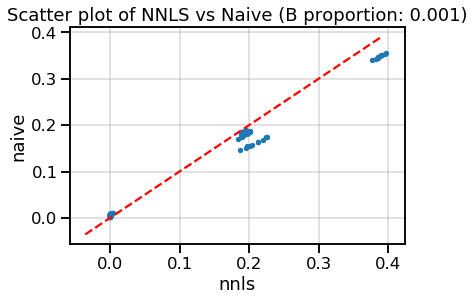

In [418]:
idx=3
testing_naive[idx] = testing_naive[idx].reindex(testing[idx].index)
testing_naive[idx] = testing_naive[idx].melt()['value']

testing_naive[idx] = testing_naive[idx]
testing[idx] = testing[idx].melt()['value']

# concate the long col from naive and nnls
df_ = pd.DataFrame({'nnls': testing[idx], 'naive': testing_naive[idx]})
df_.head()

# Assuming df is your DataFrame

plt.scatter(df_['nnls'], df_['naive'], s=15)


# Calculate the range of your data
data_range = [df_['nnls'].min(), df_['naive'].max()]

# Extend the range by 10%
extended_range = [data_range[0] - 0.1 * (data_range[1] - data_range[0]), 
                  data_range[1] + 0.1 * (data_range[1] - data_range[0])]

# Draw a diagonal line
plt.plot(extended_range, extended_range, color='red', linestyle='--')


plt.xlabel('nnls')
plt.ylabel('naive')
plt.title('Scatter plot of NNLS vs Naive (B proportion: 0.001)')

plt.grid(True, alpha=0.5)
plt.gca().set_axisbelow(True)

plt.show()

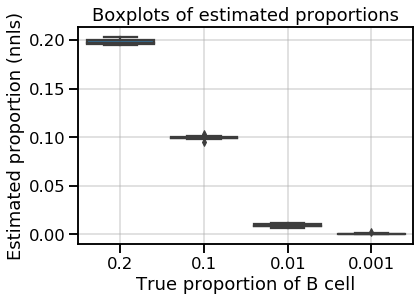

In [322]:

CELL_TYPE = 'immune_b'
TRUE_PROPORTIONS = [0.2, 0.1, 0.01, 0.001]

dfs = []

for i in range(0, len(testing)):
    df = testing[i]
    phat = df[df.index == CELL_TYPE].values.squeeze()
    p_idx = np.repeat(TRUE_PROPORTIONS[i], len(phat))
    df = {'idx': p_idx, 'phat': phat}
    df = pd.DataFrame(df)
    df['idx'] = df['idx'].astype(str)
    dfs.append(df)

df = pd.concat(dfs)


sns.boxplot(x='idx', y='phat', data=df)

plt.title('Boxplots of estimated proportions')
plt.xlabel('True proportion of B cell')
plt.ylabel('Estimated proportion (nnls)')

plt.grid(True, alpha=0.5)
plt.gca().set_axisbelow(True)

plt.show()

In [318]:
df = testing[3] 
phat = df[df.index == CELL_TYPE].values.squeeze()
np.correlate(phat, PROPORTIONS[3])

array([0.00030911, 0.00036095, 0.00043955, 0.00073308, 0.0009695 ])

In [320]:
PROPORTIONS[3]

array([0.001 , 0.1998, 0.1998, 0.1998, 0.1998, 0.1998])

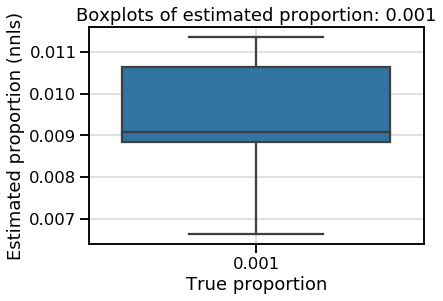

In [349]:

CELL_TYPE = 'immune_b'
TRUE_PROPORTIONS = [0.001]
testing_ = [testing[2]]

dfs = []

for i in range(0, len(testing_)):
    df = testing_[i]
    phat = df[df.index == CELL_TYPE].values.squeeze()
    p_idx = np.repeat(TRUE_PROPORTIONS[i], len(phat))
    df = {'idx': p_idx, 'phat': phat}
    df = pd.DataFrame(df)
    df['idx'] = df['idx'].astype(str)
    dfs.append(df)

df = pd.concat(dfs)


sns.boxplot(x='idx', y='phat', data=df)

plt.title('Boxplots of estimated proportion: 0.001')
plt.xlabel('True proportion')
plt.ylabel('Estimated proportion (nnls)')

plt.grid(True, alpha=0.5)
plt.gca().set_axisbelow(True)

plt.show()

In [246]:
# detect at some threshold

CELL_TYPE = 'immune_b'
DETECTION_THRESHOLD = 0.000001

p_detect = []

for df in testing:
    m, n = df.shape
    phat = df[df.index == CELL_TYPE]
    phat_boolean = phat > DETECTION_THRESHOLD
    p_detected = sum(phat_boolean.values.squeeze()) / n
    p_detect.append(p_detected)
 
p_detect

[1.0, 1.0, 1.0, 0.7]

In [341]:
# detect with close to true proportion
CELL_TYPE = 'immune_b'
TRUE_PROPORTIONS = [0.2, 0.1, 0.01, 0.001]
EPS = [0.2, 0.1, 0.01, 0.001]

p_correct = []

for i in range(0,len(testing)):
    df = testing[i]
    m, n = df.shape
    eps = EPS[i] * 0.2
   # eps = df.std(axis=1)[0] * 1.5
    true_p = TRUE_PROPORTIONS[i]
    true_p_min = true_p - eps 
    true_p_max = true_p + eps
    phat = df[df.index == CELL_TYPE]
    phat = phat.values.squeeze()
    phat_boolean = [(true_p_min <= x <= true_p_max) for x in phat]
    p_correct.append(sum(phat_boolean) / n)

p_correct 

[1.0, 1.0, 0.9, 0.3]

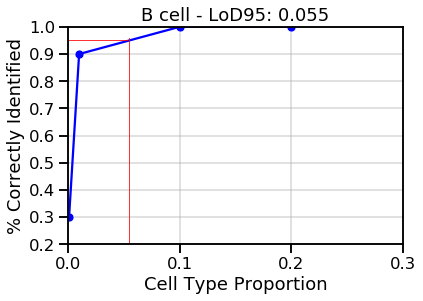

In [347]:
# Replace these with your data
x_values = TRUE_PROPORTIONS
y_values = p_correct  #  p_correct #

# Sorting the x_values and y_values in the order of x_values
sorted_indices = np.argsort(x_values)
x_values_sorted = np.array(x_values)[sorted_indices]
y_values_sorted = np.array(y_values)[sorted_indices]

# Interpolating to find the x-value
y_target = 0.95
x_target = np.interp(y_target, y_values_sorted, x_values_sorted)

# Create a scatter plot
sns.scatterplot(x=x_values, y=y_values, color='b')

# Create a line plot
sns.lineplot(x=x_values, y=y_values, color='b')

# Set the limits and spacing of the x and y axes
plt.xticks(ticks=[i/10 for i in range(11)])
plt.yticks(ticks=[i/10 for i in range(11)])
# plt.xlim(0, 0.3)
# plt.ylim(0.6, 1)
plt.xlim(0, 0.3)
plt.ylim(0.2, 1)


# Drawing horizontal and vertical lines
plt.axhline(y=y_target, xmin=0, xmax=x_target+0.12, color='r', linestyle='-', linewidth=0.8)
plt.axvline(x=x_target, ymin=0, ymax=y_target, color='r', linestyle='-', linewidth=0.8)

plt.grid(True, alpha=0.5)
plt.gca().set_axisbelow(True)

plt.xlabel('Cell Type Proportion')
plt.ylabel('% Correctly Identified')
plt.title('B cell - LoD95: ' + str(round(x_target,3)))

plt.show()

In [ ]:
# use variation within each cell type proportion 